In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
dataframe = pd.read_csv('rice.csv')

In [18]:
dataframe.shape

(100000, 5)

In [19]:
dataframe.head()

,Soil_Moisture,Temperature,Humidity,Time,Status
0,54,22,70,21,1
1,12,20,40,104,0
2,34,26,35,62,1
3,7,44,44,93,0
4,50,38,23,92,0


In [20]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 80000 samples for training and 20000 for validation


In [21]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Status")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [22]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Soil_Moisture': <tf.Tensor: shape=(), dtype=int64, numpy=13>, 'Temperature': <tf.Tensor: shape=(), dtype=int64, numpy=8>, 'Humidity': <tf.Tensor: shape=(), dtype=int64, numpy=41>, 'Time': <tf.Tensor: shape=(), dtype=int64, numpy=89>}
Target: tf.Tensor(1, shape=(), dtype=int64)


In [23]:
train_ds = train_ds.batch(100)
val_ds = val_ds.batch(100)

In [24]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [25]:
Soil_Moisture = keras.Input(shape=(1,),name="Soil_Moisture")
Temperature = keras.Input(shape=(1,),name="Temperature")
Humidity = keras.Input(shape=(1,),name="Humidity")
Time = keras.Input(shape=(1,),name="Time")

all_inputs = [
   Soil_Moisture,
   Temperature,
   Humidity,
   Time
]

Soil_Moisture_encoded = encode_numerical_feature(
    Soil_Moisture, "Soil_Moisture", train_ds)
Temperature_encoded = encode_numerical_feature(
    Temperature, "Temperature", train_ds)
Humidity_encoded = encode_numerical_feature(
    Humidity, "Humidity", train_ds)
Time_encoded = encode_numerical_feature(
    Time, "Time", train_ds)

all_features = layers.concatenate(
    [
        Soil_Moisture_encoded,
        Temperature_encoded,
        Humidity_encoded,
        Time_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="relu")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

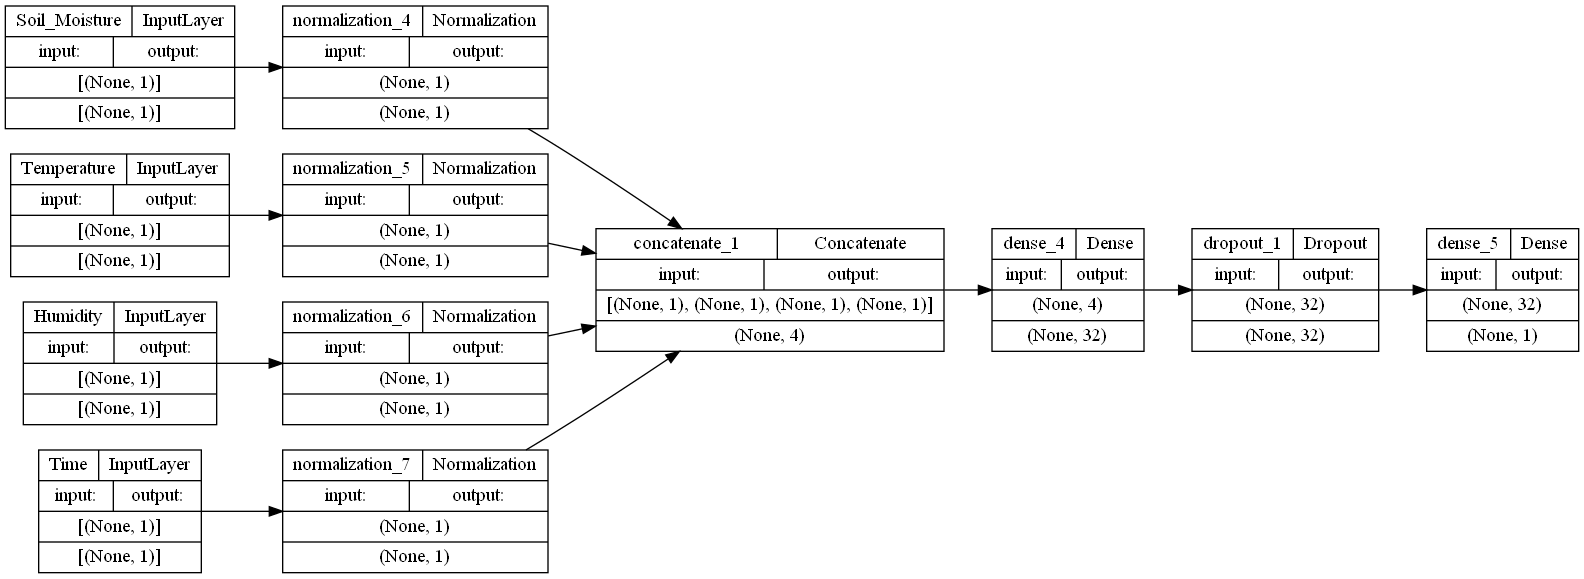

In [26]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [27]:
model.fit(train_ds, epochs=30, batch_size=5, validation_data=val_ds)


Epoch 1/30
800/800 [==============================] - 5s 5ms/step - loss: 2.2685 - accuracy: 0.6108 - val_loss: 0.7985 - val_accuracy: 0.7170
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 1.1392 - accuracy: 0.6612 - val_loss: 0.6173 - val_accuracy: 0.7244
Epoch 3/30
800/800 [==============================] - 4s 4ms/step - loss: 0.8236 - accuracy: 0.6766 - val_loss: 0.5999 - val_accuracy: 0.7128
Epoch 4/30
800/800 [==============================] - 4s 4ms/step - loss: 0.6786 - accuracy: 0.6787 - val_loss: 0.5440 - val_accuracy: 0.7157
Epoch 5/30
800/800 [==============================] - 3s 4ms/step - loss: 0.6255 - accuracy: 0.6967 - val_loss: 0.5171 - val_accuracy: 0.7271
Epoch 6/30
800/800 [==============================] - 4s 4ms/step - loss: 0.5856 - accuracy: 0.7076 - val_loss: 0.4972 - val_accuracy: 0.7359
Epoch 7/30
800/800 [==============================] - 4s 4ms/step - loss: 0.5533 - accuracy: 0.7255 - val_loss: 0.4805 - val_accuracy: 0.7558
Epoch 

In [32]:
sample = {
    "Soil_Moisture": 100,
    "Temperature": 26,
    "Humidity": 89,
    "Time": 30
}

input_dict = {name: tf.convert_to_tensor(
    [value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "Tanaman ini %.1f percent perlu disiram " % (
        100 * predictions[0][0],)
)


Tanaman ini 0.0 percent perlu disiram 


In [29]:
model.save('model.h5')